In [ ]:
%pip install lime

In [ ]:
# Downloading dataset:
import kagglehub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:01<00:00, 141MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [ ]:
# Other imports:

# General Utility Imports
import pathlib
import os
from google.colab import drive
drive.mount('/content/drive')

#LIME imports
from lime import lime_image

#Math
import numpy as np

#visualisation
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries


#Pre Trained Model Import
from tensorflow.keras.applications import EfficientNetB1

# Deep Learning Imports
import tensorflow as tf


Mounted at /content/drive


In [ ]:
# Making a Dataset object
train_ds = tf.keras.preprocessing.image_dataset_from_directory(os.path.join(path,"Training"),image_size=(240,240),batch_size=32,label_mode='int',shuffle=True)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(os.path.join(path,"Testing"),image_size=(240,240),batch_size=32,label_mode='int',shuffle=True)
class_names = train_ds.class_names

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


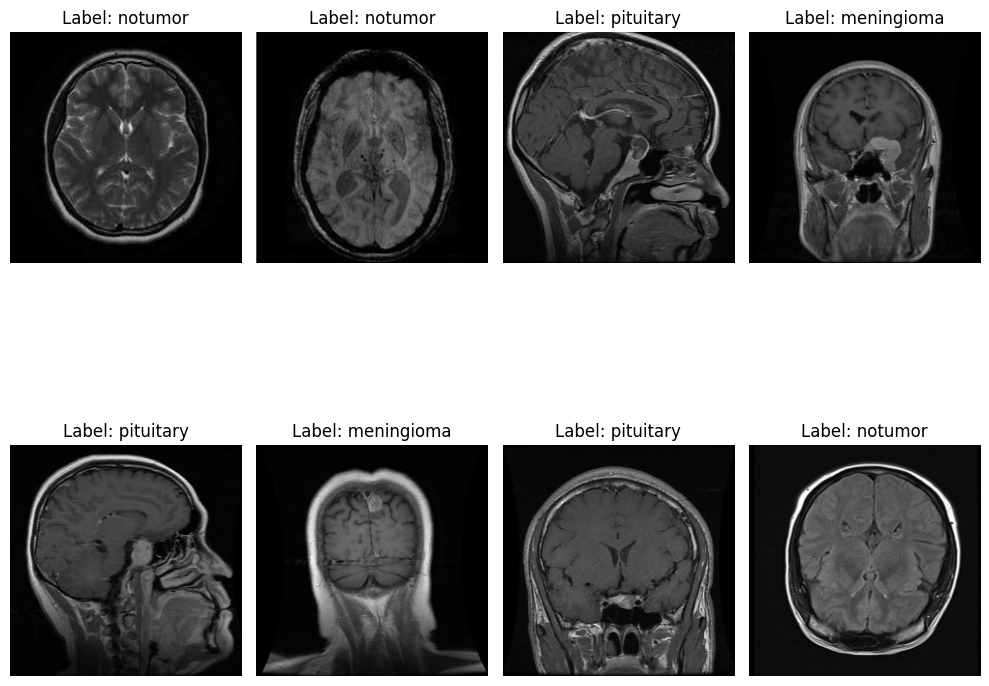

In [ ]:
#Visualising a single batch

for images,labels in train_ds.take(1):
  plt.figure(figsize=(10,10))
  for i in range(8):
    ax = plt.subplot(2,4,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Label: {class_names[labels[i]]}")
    plt.axis("off")
  plt.tight_layout()
  plt.show()

In [ ]:
# Data Augmentation Definition

img_augmentation_layers = [
    tf.keras.layers.RandomBrightness(factor=0.1),
    tf.keras.layers.GaussianNoise(stddev=0.05),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomContrast(factor=0.1)
]


def augment_img(image):
  for layer in img_augmentation_layers:
    image = layer(image)
  return image


def input_preprocess_test(image, label):
    label = tf.one_hot(label, 4)
    return image, label


def input_preprocess_train(image, label):
    image = augment_img(image)
    label = tf.one_hot(label, 4)
    return image, label


In [ ]:
# Applying Data Augmentation and Computation efficiency stuff


train_ds = train_ds.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
# building the model to initialise transfer learning:
def build_model(num_classes):
  inputs = tf.keras.Input(shape=(240,240,3))
  model = EfficientNetB1(include_top=False,input_tensor = inputs, weights='imagenet')
  model.trainable = False
  x = tf.keras.layers.GlobalAveragePooling2D()(model.output)
  x = tf.keras.layers.BatchNormalization()(x)
  top_dropout_rate = 0.2
  x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)
  # Compiling the model:

  model = tf.keras.Model(inputs, outputs, name="EfficientNet")
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
  model.compile(
      optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
  )
  return model


# Displaying statistics:

def show_stats(history):
  plt.plot(history.history["accuracy"])
  plt.plot(history.history["val_accuracy"])
  plt.title("model accuracy")
  plt.ylabel("accuracy")
  plt.xlabel("epoch")
  plt.legend(["train", "test"], loc="upper left")
  plt.show()


27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 114s 454ms/step - accuracy: 0.7694 - loss: 0.9678 - val_accuracy: 0.8574 - val_loss: 0.4286
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 46s 257ms/step - accuracy: 0.8701 - loss: 0.6138 - val_accuracy: 0.8665 - val_loss: 0.4958
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 83s 262ms/step - accuracy: 0.8574 - loss: 0.7250 - val_accuracy: 0.8902 - val_loss: 0.4105
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 46s 258ms/step - accuracy: 0.8795 - loss: 0.5250 - val_accuracy: 0.8772 - val_loss: 0.5146
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 46s 256ms/step - accuracy: 0.8718 - loss: 0.5537 - val_accuracy: 0.8947 - val_loss: 0.3402
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 252ms/step - accuracy: 0.8825 - loss: 0.4648 - val_accuracy: 0.9008 - val_loss: 0.3543
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 46s 255ms/step - accuracy: 0.8708 - loss: 0.5209 - val_accuracy: 0.8703 - val_loss: 0.4981
Epoch 8/30
179/179 ━━━━━━━━━━━━

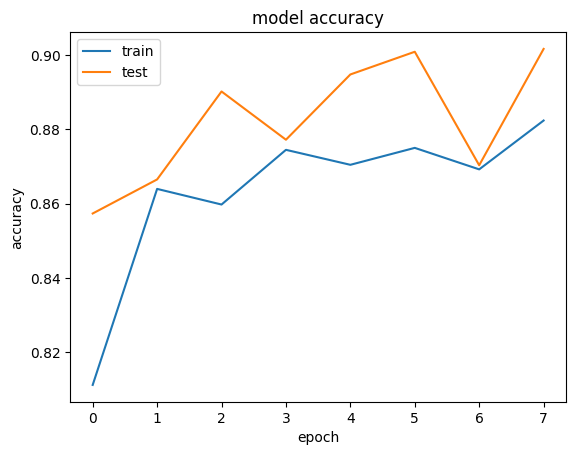

In [ ]:
model = build_model(num_classes=4)
# Setting Early Stopping:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(train_ds, epochs=30, validation_data=test_ds,callbacks=[early_stopping])
show_stats(history)


In [ ]:
SAVE_PATH = 'brain_tumor_model_2.keras'
model.save(SAVE_PATH)


In [ ]:
# load saved model:

#model = tf.keras.models.load_model('brain_tumor_model_1.keras')
res=model.evaluate(test_ds)
print("Accuracy: ",res[1])

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8875 - loss: 0.4006
Accuracy:  0.8947368264198303


In [ ]:
!pwd ; ls

/content
drive  sample_data


In [ ]:
model.summary()

Model: "EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 240, 240, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 240, 240, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 240, 240, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 240, 240, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 241, 241, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 120, 120, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 120, 120, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 120, 120, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 120, 120, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 120, 120, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 120, 120, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 6,600,853 (25.18 MB)

 Trainable params: 7,684 (30.02 KB)

 Non-trainable params: 6,577,799 (25.09 MB)

 Optimizer params: 15,370 (60.04 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Original label:  meningioma
This image likely belongs to the class: 'glioma' with a score of 0.4656597077846527


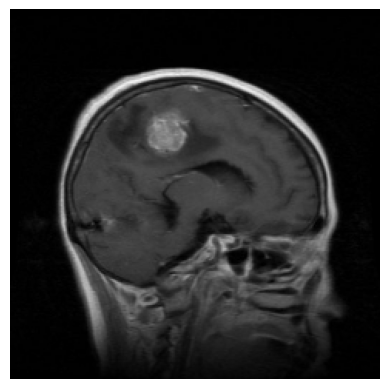

In [ ]:
# Taking a single image and corresponding prediction:
for image,label in test_ds.take(1):
  image=image[0]
  label=label[0]
  image_array = tf.keras.utils.img_to_array(image)
  plt.imshow(image_array/255.0)
  plt.axis("off")
  break

image_array_extended = tf.expand_dims(image_array, 0) # Create a batch
original_model_prediction = model.predict(image_array_extended)
label_index = tf.argmax(label).numpy()
print("Original label: ", class_names[label_index])
score = tf.nn.softmax(original_model_prediction[0])
print(f"This image likely belongs to the class: '{class_names[np.argmax(score)]}' with a score of {np.max(score)}")

plt.show()


image_array = np.expand_dims(image_array, 0)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

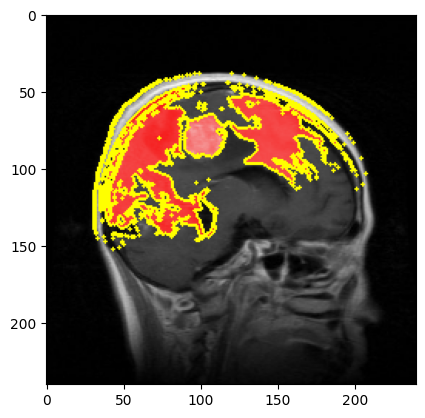

In [ ]:
# Explaining with LIME


explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image = image_array[0],
    classifier_fn = model.predict,
    top_labels = 5,
    hide_color = 0,
    num_samples = 1000
)

temp,mask = explanation.get_image_and_mask(
    label = explanation.top_labels[0],
    positive_only = False,
    hide_rest = False,
    num_features = 15,
    min_weight = 0.09
)


plt.imshow(mark_boundaries(temp/255.0,mask))
plt.show()
